<a href="https://colab.research.google.com/github/MargaritaLopezG/Python_codes/blob/main/KAML_catalogues_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Supervised Regression problem

In this notebook we will use neural network algorihtms to learn a mapping between galaxy magnitudes and colors and the spectroscopic redshift.



# Load some libraries

In [1]:
pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 47.8 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.model_selection import train_test_split

# Doanload the dataset

In [3]:
from astroquery.sdss import SDSS

# look for availabe tables and columns in
# http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx

query = " SELECT TOP 200000 objID, ra ,dec, z, zerr, class, \
        cModelMag_r as mag_r, cModelMag_g as mag_g, cModelMag_i as mag_i, \
        cModelMag_u as mag_u, cModelMag_z as mag_z \
        FROM  SpecPhotoAll  WHERE (class = 'GALAXY') \
        AND z>0.1 AND z<1. AND ra>200 AND ra<230 AND dec>10 AND dec<40"


d = SDSS.query_sql(query)

If the above query fails try the following...

In [ ]:
#import pandas as pd
#d = pd.read_csv("https://archive.kasi.re.kr/bigdata/temp/KAML_catalogues_regression.csv ", header=0)


# Clean the data

In [ ]:
#you can look at the all the features available to you
# http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+PhotoObj+V

print (d.keys())

# for photo-z work
# The target/label values are spectroscopic redshifts

In [4]:
# we will use just dereddend magnitudes
mags = ['mag_g', 'mag_r', 'mag_i','mag_z','mag_u']
d=d[d[mags[0]]==d[mags[0]]]
d=d[d[mags[1]]==d[mags[1]]]
d=d[d[mags[2]]==d[mags[2]]]
d=d[d[mags[3]]==d[mags[3]]]
d=d[d[mags[4]]==d[mags[4]]]

def f(x):
    return float(x)
f2 = np.vectorize(f)

#and color combinations created from them.
cols= []
for i in range(len(mags)-1):
    for j in range(i, len(mags)):
        cols.append(mags[i]+'-' + mags[j])

# let's load these into an input array
inputs = np.zeros((len(d), len(mags+cols)), dtype=float)
for i, key in enumerate(mags):
    inputs[:, i] = np.array(d[key])

cnt = len(mags)
for i in range(len(mags)-1):
    for j in range(i, len(mags)):
        inputs[:, cnt] = np.array(f2(d[mags[i]])) - np.array(f2(d[mags[j]]))
        cnt += 1


In [5]:
targets = np.array(f2(d['z']))

# we will split the data into a trainind and testing sample.


In [6]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.4, random_state=42)

print("Training inputs: ",x_train.shape)
print("Training outputs: ",y_train.shape)
print("Testing inputs: ",x_test.shape)
print("Testing outputs: ",y_test.shape)

Training inputs:  (98968, 19)
Training outputs:  (98968,)
Testing inputs:  (65979, 19)
Testing outputs:  (65979,)


# Import Tensorflow

In [7]:
import tensorflow as tf

In [8]:
def get_compiled_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(19,)),
      tf.keras.layers.Dense(64, activation='sigmoid'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

model = get_compiled_model()
model.build()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
hist=model.fit(x_train,y_train,validation_split=0.2,epochs=10,batch_size=128,shuffle=True)

Epoch 1/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0572 - val_loss: 0.0100
Epoch 2/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 3/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 4/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 5/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 6/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 7/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 9/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 10/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0079 - val_loss: 0.0078


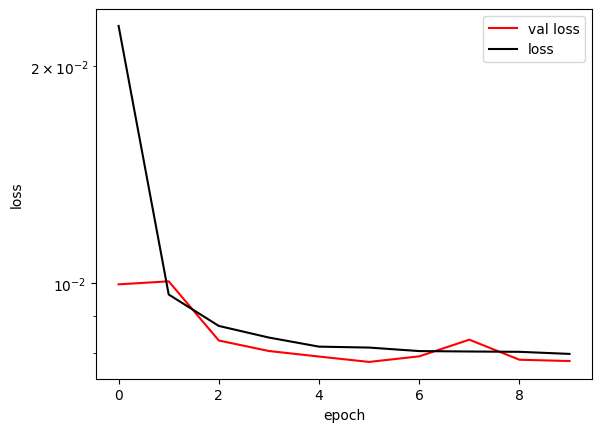

In [10]:
plt.plot(hist.history['val_loss'],'r-',label='val loss')
plt.plot(hist.history['loss'],'k-',label='loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()

Is the model still learning? Are both the loss and val_loss decreasing? When should we stop training?

In [11]:
# let's add a stopping criteria
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = get_compiled_model()
hist=model.fit(x_train,y_train,validation_split=0.2,epochs=100,batch_size=128,shuffle=True,callbacks=[callback])

Epoch 1/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1146 - val_loss: 0.0112
Epoch 2/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109 - val_loss: 0.0094
Epoch 3/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 4/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0089 - val_loss: 0.0084
Epoch 5/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 6/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 7/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 9/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 10/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 11/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 12/100
619/619 ━━━━━━━━━━━━━━━━━━━━

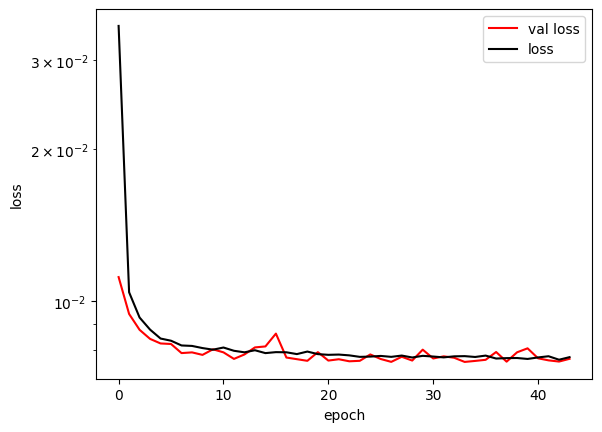

In [12]:
plt.plot(hist.history['val_loss'],'r-',label='val loss')
plt.plot(hist.history['loss'],'k-',label='loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()

2062/2062 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


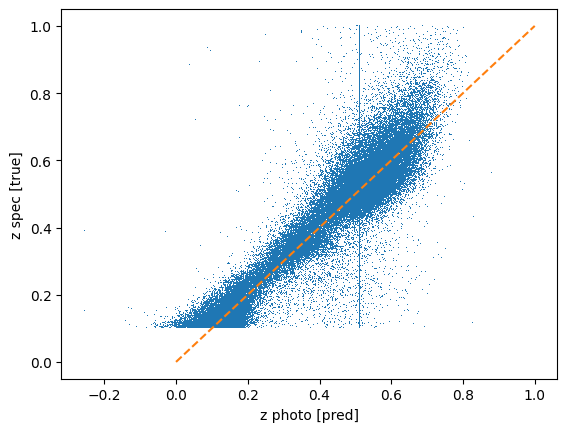

In [13]:
pred=model.predict(x_test).squeeze()

plt.plot(pred,y_test,',')
plt.plot([0, 1],[0, 1],'--')
plt.ylabel('z spec [true]')
plt.xlabel('z photo [pred]')
plt.show()

dispersion:  0.055696703


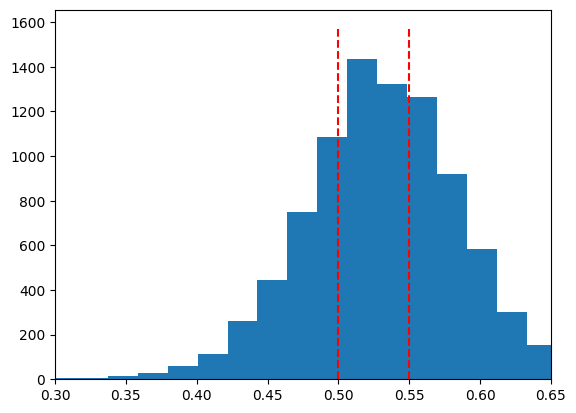

In [14]:
specz=[0.5,0.55]
a=plt.hist(pred[(y_test>specz[0]) & (y_test<specz[1])],30)
plt.plot([specz[0],specz[0]],[0,1.1*np.max(a[0])],'r--')
plt.plot([specz[1],specz[1]],[0,1.1*np.max(a[0])],'r--')
plt.xlim((0.3,0.65))

print('dispersion: ',np.std(pred[(y_test>specz[0]) & (y_test<specz[1])]))

Sometimes the best model (lowest val_loss) is not the last epoch. So lets restore the weights of the model with the lowest val_loss.

In [15]:
# let's save and restore the best model
call_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.weights.h5',
                                              save_weights_only=True,
                                              monitor='val_loss',
                                              mode='min',
                                              save_best_only=True)

model = get_compiled_model()
hist=model.fit(x_train,y_train,validation_split=0.2,epochs=100,batch_size=128,shuffle=True,callbacks=[callback, call_save])

Epoch 1/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0163 - val_loss: 0.0100
Epoch 2/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 3/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 4/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 5/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083 - val_loss: 0.0078
Epoch 6/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 7/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 8/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 9/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 10/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 11/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 12/100
619/619 ━━━━━━━━━━━━━━━━━━━━

2062/2062 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


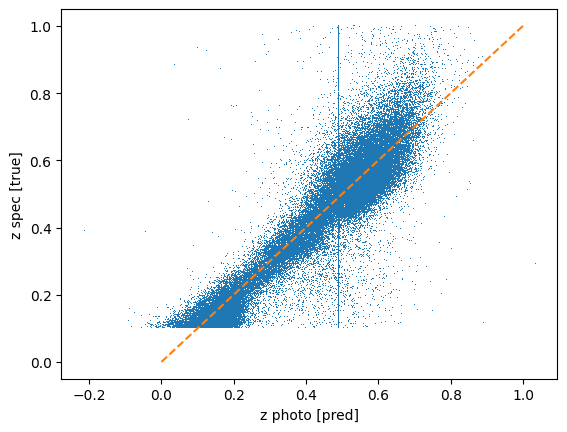

In [16]:
# now restore the best model before prediction
model.load_weights('best_model.weights.h5')

pred=model.predict(x_test).squeeze()

plt.plot(pred,y_test,',')
plt.plot([0, 1],[0, 1],'--')
plt.ylabel('z spec [true]')
plt.xlabel('z photo [pred]')
plt.show()


# Assignment 3:


*   Try different activation functions and learning rates
*   What is the best val_loss you can get
*   What is the lowest dispersion on for 0.5< spec z < 0.55



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2062/2062 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


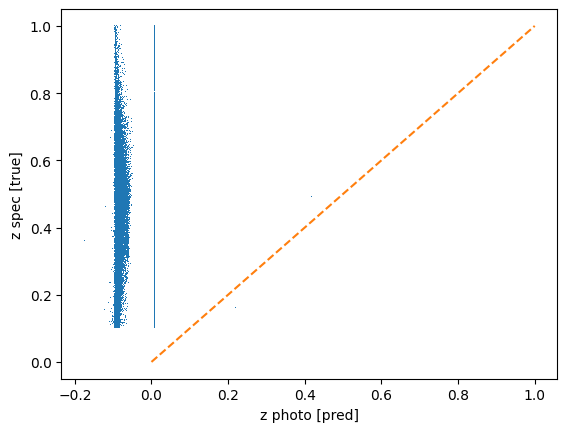

In [17]:
def get_compiled_model():
  model2 = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(19,)),
      tf.keras.layers.Dense(64, activation='softmax'),
      tf.keras.layers.Dense(1)
  ])

  model2.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model2

model2 = get_compiled_model()
model2.build()
model2.summary()

model2.load_weights('best_model.weights.h5')

for i in range(0.5,0.55):
  model2 = get_compiled_model(i)
  hist=model2.fit(x_train,y_train,validation_split=0.2,epochs=100,batch_size=128,shuffle=True,callbacks=[callback])


pred=model2.predict(x_test).squeeze()

plt.plot(pred,y_test,',')
plt.plot([0, 1],[0, 1],'--')
plt.ylabel('z spec [true]')
plt.xlabel('z photo [pred]')
plt.show()
